<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 11th exercise: <font color="#C70039">Interpretable Machine Learning with LIME for Image Classification</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Rubaiya Kabir Pranti</a>
* Matriculation Number: <a href="https://www.gernotheisenberg.de/"> 11146364</a>
* Date:   16.01.2024

<img src="https://miro.medium.com/max/1400/1*K4HCitQxRrjcFekIsSZDSg.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
LIME stands for Local Interpretable Model-agnostic Explanations and was developed by Ribeiro et.al. in 2016 (https://arxiv.org/abs/1602.04938).

In this notebook LIME is going to be used to generate explanations for an image classification task. 
The basic idea applying LIME is to understand why a deep neural network predicts that an instance (image) belongs to a certain class (labrador in this case). 
This notebook is based on previous work by Cristian Arteaga, [arteagac.github.io](https://arteagac.github.io)

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. test your own images to obtain explanations for your classification tasks.
5. change some hyperparameters
6. describe your observations and the LIME performance
---------------------------------

## Imports
Import all necessary python utilities for manipulation of images, plotting and numerical analysis.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from   tensorflow.keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from   sklearn.linear_model import LinearRegression
import warnings

np.random.seed(666)

C:\Users\rubai\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## InceptionV3 initialization
We are going to use the pre-trained InceptionV3 model available in Keras.

### <font color="FFC300">InceptionV3 == Global Complex model == Blackbox model</font>:

In [2]:
warnings.filterwarnings('ignore') 
inceptionV3_model = tensorflow.keras.applications.inception_v3.InceptionV3() #Load pretrained model

### Read and pre-process image
The instance to be explained (image) is resized and pre-processed to be suitable for Inception V3. This image is saved in the variable `Xi`. 

## Specific one input image : American_Staffordshire_terrier

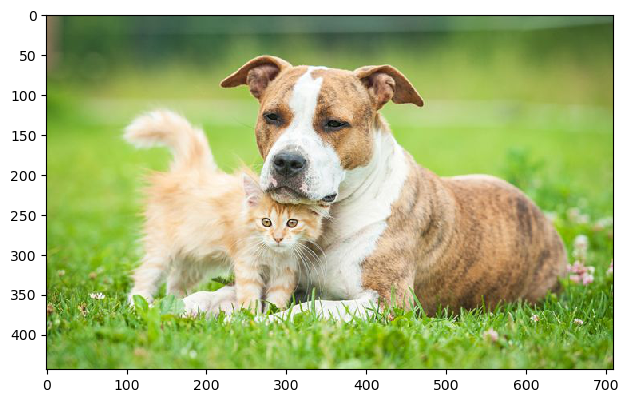

In [3]:
Xi = skimage.io.imread('C:/Users/rubai/AML/data/American_Staffordshire_terrier.jpg') # into an array Xi
skimage.io.imshow(Xi)

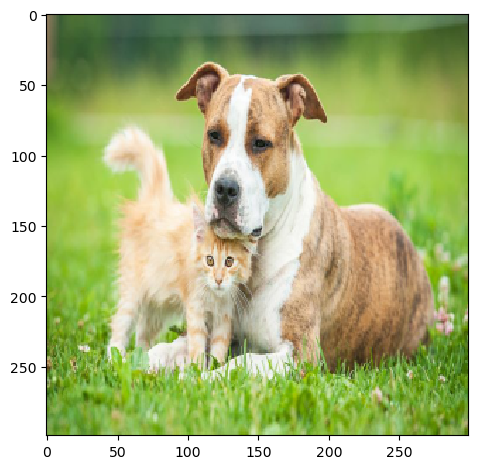

In [4]:
Xi = skimage.transform.resize(Xi, (299,299)) #Inception model expects input images to be of (299,299) size
Xi = (Xi - 0.5)*2 #Inception pre-processing
# above normalization step is specific to the Inception v3 model as it was utilized during the training of the model itself 
# the pixel values, originally is in the range [0, 1], are shifted by 0.5 so that it would be in the range [-0.5, 0.5] 
# and then it is scaled by a factor of 2 to be in the range [-1, 1]
skimage.io.imshow(Xi/2+0.5) # original resized image showing
# the transformation (Xi/2+0.5) is undoing the preprocessing to bring the pixel values back to 
# the range [0, 1] for visualization purposes

## Predict the class of the input image
The Inception V3 model is used to predict the class of the image. The output of the classification is a vector of 1000 proabilities of beloging to each class available in Inception V3. The description of these classes is shown and it can be seen that the "American_Staffordshire" is the top class for the given image.

In [5]:
np.random.seed(666)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
# preds will contain batch of images
# preds[0] means that 1st image within a batch
# np.newaxis is used to add an extra dimension to the Xi array, 
# converting it from a 3D array of shape (height, width, channels) to a 4D array of shape (1, height, width, channels). 
# it is necessary because the predict method expects a batch of images to make predictions on, not a single image
# by adding the np.newaxis, i am creating a batch with one image
# preds is the variable where the predictions made by the model are being stored
# these predictions are output as a 'probability distribution' across all possible classes that the model can recognize

1/1 [==============================] - 3s 3s/step


In [6]:
preds
# it outputs nothing but all rows with different predictions for 1000 classes
# the model is trained to recognize 1,000 classes, the output will be an array of 1,000 probabilities.
# The value at each index is the probability that the image belongs to that one particular class

array([[3.13830591e-04, 4.62791155e-04, 4.53728950e-04, 6.35120203e-04,
        4.34813439e-04, 6.66947279e-04, 2.06971716e-04, 8.72436212e-04,
        3.93170310e-04, 1.30197324e-04, 3.36645171e-04, 2.80285865e-04,
        1.66348167e-04, 2.27626035e-04, 7.22591067e-04, 4.18146607e-04,
        2.76482693e-04, 2.19811322e-04, 4.25416336e-04, 2.63377529e-04,
        7.35992449e-04, 1.52881592e-04, 2.95197096e-04, 2.75426457e-04,
        4.73946217e-04, 2.76616658e-04, 5.34104591e-04, 2.79980508e-04,
        3.98251286e-04, 1.18382927e-03, 7.53683096e-04, 4.52143897e-04,
        2.95060570e-04, 3.06021509e-04, 7.85798591e-04, 9.37017554e-04,
        2.12297789e-04, 4.06909152e-04, 6.19652797e-04, 3.91798123e-04,
        3.60854436e-04, 3.09997820e-04, 2.17605731e-04, 2.29465135e-04,
        4.14255832e-04, 3.27476504e-04, 5.42594178e-04, 2.14557382e-04,
        7.94070947e-04, 6.91797992e-04, 4.00620484e-04, 1.52863009e-04,
        5.77495084e-04, 4.02638048e-04, 2.77907151e-04, 9.591862

In [7]:
decode_predictions(preds)
# it returns a list for each image in the batch 
# 'decode_predictions' function returns the top 5 most possible classes predicted by the complex model for our given image
# as we have one image only, the list is also for one image

[[('n02093428', 'American_Staffordshire_terrier', 0.22549662),
  ('n02093256', 'Staffordshire_bullterrier', 0.22262669),
  ('n02110806', 'basenji', 0.038801648),
  ('n02113186', 'Cardigan', 0.013671333),
  ('n02094114', 'Norfolk_terrier', 0.012004164)]]

In [8]:
# for first image> [0] used
decode_predictions(preds)[0] #Top 5 classes #and only used for human readability purpose
# above one is a utility function within inception v3
# it translates the output==probability distributions over classes of the model
# into a list of human-readable class names with their associated probabilities
# we select the first (one and only) element in the list for now, which corresponds to our one given image

[('n02093428', 'American_Staffordshire_terrier', 0.22549662),
 ('n02093256', 'Staffordshire_bullterrier', 0.22262669),
 ('n02110806', 'basenji', 0.038801648),
 ('n02113186', 'Cardigan', 0.013671333),
 ('n02094114', 'Norfolk_terrier', 0.012004164)]

The indexes (positions) of the top 5 classes are saved in the variable `top_pred_classes`

In [9]:
# there is no order within the indices
#  argsort() is NumPy function that returns the indices
#  result is an array of indices arranged from the ''least likely to the most likely prediction''
top_pred_classes = preds[0].argsort()
top_pred_classes

array([249, 662, 372, 221, 104, 417, 380, 571, 381, 287, 470, 469, 505,
       613, 313, 355, 165, 523, 160, 827, 368, 909, 178, 476, 191, 692,
       442, 480, 727, 830, 293, 771, 229, 284, 960, 346, 296, 921, 378,
       928, 754, 636, 652, 271, 884,  78, 344, 724, 205, 235, 737, 272,
       762, 477, 498,   9, 510, 126, 708, 702, 371, 456, 280, 883, 544,
       461, 933, 796, 542, 903, 351, 627, 452, 668, 265, 853, 895, 237,
       601, 259, 358, 226, 849, 244, 406, 407, 388, 603, 774,  51,  21,
       874, 334, 687, 611, 526, 738, 387, 129, 671, 124, 217, 492, 812,
       685, 277, 725, 506, 755, 540, 176, 444, 225, 863, 715, 585, 251,
        12, 632, 466, 370, 593, 699, 664, 765, 690, 612, 501, 847, 451,
        83, 494, 278, 377, 666, 382, 868, 148, 711, 550, 829, 918, 454,
       989, 804, 383, 211, 875, 330, 201, 374, 441, 994, 686, 386, 716,
       295, 213, 286, 823, 385, 342, 864, 343, 914, 996, 739, 239, 784,
       482, 901, 411,  93, 267, 219, 810, 450, 134, 297, 500, 38

In [10]:
top_pred_classes = preds[0].argsort()[-5:]
# last five elements of the sorted indices

In [11]:
top_pred_classes = preds[0].argsort()[-5:][::-1] 
# now after using, [::-1], top_pred_classes contains the indices of the top 5 predictions in descending order, 
# means that the most likely prediction is first

In [12]:
top_pred_classes #Index of top 5 classes

array([180, 179, 253, 264, 185], dtype=int64)

## LIME explanations
The following figure illustrates the basic idea behind LIME. The figure shows light and dark gray areas which are the decision boundaries for the classes for each (x1,x2) pairs in the dataset. LIME is able to provide explanations for the predictions of an individual record (blue dot). The  explanations are created by generating a new dataset of perturbations around the instance to be explained (colored markers around the blue dot). The output or class of each generated perturbation is predicted with the machine-learning model (colored markers inside and outside the decision boundaries). The importance of each perturbation is determined by measuring its distance from the original instance to be explained. These distances are converted to weights by mapping the distances to a zero-one scale using a kernel function (see color scale for the weights). All this information: the new generated dataset, its class predictions and its weights are used to fit a simpler model, such as a linear model (blue line), that can be interpreted. The attributes of the simpler model, coefficients for the case of a linear model, are then used to generate explanations.  
<img src="./images/lime_illustration.png" alt="LIME" width="600"/>

A detailed explanation of each step is shown below.

## Step 1: Create perturbations of image
For the case of image explanations, perturbations will be generated by turning on and off some of the superpixels in the image.

## <font color="FFC300">Comment</font>:
perturbations are for -
1. generating variations or can say perturbations of the given input image and acknowleding how these changes affect 
the model's predictions
2. this helps in understanding what parts of the image are vital for the model's decision



When the complex model makes a prediction on these altered or perbuteated images, the changes in its output can give valuable  insights regarding which parts of the original image were most influential in its decision-making process

#### Extract super-pixels from image
Superpixels are generated using the quickshift segmentation algorithm. It can be noted that for the given image, 69 superpixels were generated. The generated superpixels are shown in the image below.

* it is a method for creating superpixels by clustering such pixels which have color similarity and proximity in its image space
to provide visually meaningful clusters of pixels

In [13]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
# if a superpixel is 'turned off', it could be blacked out or hiding that part of the image from the model
# max_dist parameter specifies the maximum distance between pixels that can be included in the same superpixel
# higher max_dist can lead to larger superpixels
# ratio parameter controls the trade-off between color similarity and spatial proximity 
# lower values in ratio paaram. give more chances to color similarity, 
# leading to superpixels that are more uniform in color but potentially irregular in shape
# each superpixel is represented by a unique number in the output of the quickshift function

In [32]:
superpixels
# each unique integer in the array represents a superpixel
# the same number repeated in adjacent locations indicates that those pixels belong to the same superpixel

array([[ 8,  8,  8, ...,  6,  6,  6],
       [ 8,  8,  8, ...,  6,  6,  6],
       [ 8,  8,  8, ...,  6,  6,  6],
       ...,
       [63, 63, 63, ..., 60, 60, 60],
       [63, 63, 63, ..., 60, 60, 60],
       [63, 63, 63, ..., 60, 60, 60]], dtype=int64)

In [15]:
num_superpixels = np.unique(superpixels)
num_superpixels
# effectively counts the total number of superpixels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68], dtype=int64)

In [16]:
num_superpixels = np.unique(superpixels).shape[0]
# effectively counts the total number of superpixels
# gets the size of the unique values array
num_superpixels

69

### <font color="FFC300">Comment</font>:

69 superpixels means the entire image was broken down into 69 distinct segments and each containing a group of pixels that are similar in terms of color intensity and proximity

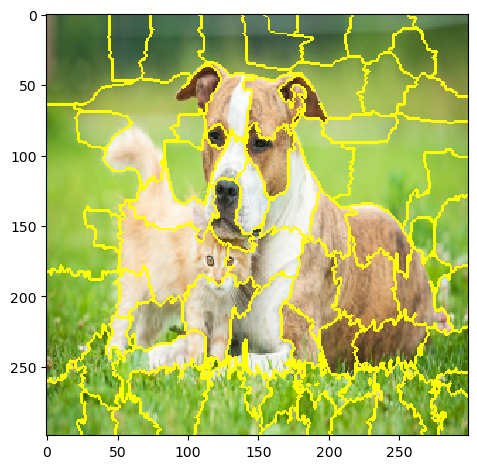

In [17]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))
#  visualizing the boundaries of superpixels on the input image
# mark_boundaries are denoting the boundaries for superpixels

## Create random perturbations
In this example, 150 perturbations were used. However, for real life applications, a larger number of perturbations will produce more reliable explanations. Random zeros and ones are generated and shaped as a matrix <u><b>with perturbations as rows and superpixels as columns</b></u>
. An example of a perturbation (the first one) is show below. Here, `1` represents that a superpixel is on and `0` represents it is off. Notice that the length of the shown vector corresponds to the number of superpixels in the image.

In [18]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
# 1 means that each superpixel is like one single experiment
# 0.5: by definition it means the probability of success for each trial
# in our case, it denotes that each superpixel has a 50% chance of being "turned on" in each perturbation

In [19]:
perturbations[0] #1st perturbation
# the only 1st perturbed image shown here, has ttoal 69 superpixels where some are turned on and some are off

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1])

In [20]:
active_pixels = np.where(perturbations[0] == 1)[0]
active_pixels
# 1st perturbed image is taken

array([ 0,  1,  2,  3,  4,  9, 11, 13, 15, 21, 24, 25, 26, 28, 30, 31, 32,
       33, 35, 38, 43, 46, 47, 48, 54, 55, 56, 58, 61, 62, 63, 68],
      dtype=int64)

In [21]:
mask = np.zeros(superpixels.shape)
mask[superpixels == active_pixels[0]] = 1
mask 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The following function `perturb_image` perturbs the given image (`img`) based on a perturbation vector (`perturbation`) and predefined superpixels (`segments`).

## Creating altered images using perturb_image:

In [22]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for i in active_pixels:
      mask[segments == i] = 1 #if mask==1, then those superpixel will remain
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis] #element-wise multiplication of two arrays
  return perturbed_image

### <font color="FFC300">Comment</font>:

* <b> active_pixels = np.where(perturbation == 1)[0]</b>: <br> it finds the indices of the perturbation array where the value is 1 (superpixels==1 or that turned on). The [0] extracts the array of indices from the resulting tuple.
* <b> mask = np.zeros(segments.shape) </b>: <br> a mask array is created with the same shape as segments or superpixels, initially filled with zeros. This mask will be used to specify which pixels in the original image should remain unchanged and which should be perturbed
* <b> perturbed_image = perturbed_image*mask[:,:,np.newaxis] </b>: <br> the mask is applied to perturbed_image and is expanded to match the dimensions of perturbed_image using np.newaxis. Pixels corresponding to active superpixels (where mask is 1) will remain, while the rest will be turned to zero  or effectively blacked out <br>
* if perturbed_image is a 3D array (with height, width, and color channels), mask needs to be transformed from a 2D array (height, width) to a 3D array (height, width, 1) to perform element-wise multiplication

Let's use the previous function to see what a perturbed image would look like:

## A perturbed image

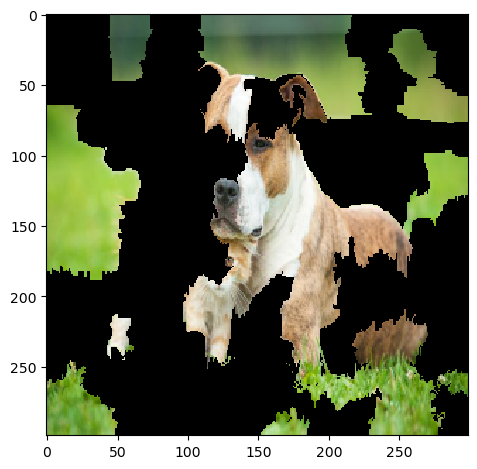

In [23]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
# only taking one single perbured image among 150 for now

### Step 2: Use ML classifier or old global complex model to predict classes of new generated/perturbed images
### <font color="FFC300">Predictions on perturbed/Altered images</font>:
This is computationally the most expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions, we can see for each of the perturbations the output probability for each of the 1000 classes in Inception V3. 

In [24]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels) #results in a perturbed version of the image
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
    # np.newaxis is used to add an extra dimension to perturbed_img, 
    # converting it into a batch with a single image, as most deep learning models expect input in batch format.
  predictions.append(pred)

predictions = np.array(predictions)
# an array of probabilities or class scores for each class that the model can predict
predictions

1/1 [==============================] - 0s 253ms/step


array([[[4.67031023e-05, 2.39868459e-04, 7.11126049e-05, ...,
         6.99075026e-05, 1.41289085e-04, 2.81507935e-04]],

       [[9.37415462e-05, 1.50107313e-04, 4.81133320e-04, ...,
         2.79095868e-04, 4.85568853e-05, 2.64096801e-04]],

       [[1.32328496e-04, 3.49839189e-04, 1.71086809e-04, ...,
         3.13581259e-04, 9.36996192e-04, 1.88138895e-03]],

       ...,

       [[2.32674007e-04, 5.15523541e-04, 5.91099670e-04, ...,
         2.95671489e-04, 8.25969968e-04, 1.49904483e-03]],

       [[1.25551873e-04, 2.37173677e-04, 2.91872479e-04, ...,
         2.90001306e-04, 1.10501780e-04, 6.26479858e-04]],

       [[1.85931094e-05, 3.53940668e-05, 3.50819028e-05, ...,
         1.04801766e-04, 1.30221088e-04, 5.87947725e-04]]], dtype=float32)

In [25]:
predictions.shape

(150, 1, 1000)

## Step 3: Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image
The distance between each randomly generated pertubation and the image being explained is computed using the cosine distance. For the shape of the `distances` array it can be noted that, as expected, there is a distance for every generated perturbation.

In [26]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
# to compute the distance between each row in perturbations and original_image
# perturbations is an array where each row represents a different perturbed version of the image with certain superpixels turned off
# cosine distance measures the cosine of the angle between two non-zero vectors
# generally saying - a common way to measure similarity between two arrays, where a lower cosine distance indicates higher similarity.
# pairwise_distances returns a 2D array , then flattened into a 1D array
distances.shape #1D array with a length equal to the number of perturbations

(150,)

### Use kernel function to compute weights
The distances are then mapped to a value between zero and one (weight) using a kernel function. An example of a kernel function with different kernel widths is shown in the plot below. Here the x axis represents distances and the y axis the weights. Depeding on how we set the kernel width, it defines how wide we want the "locality" around our instance to be. This kernel width can be set based on expected distance values. For the case of cosine distances, we expect them to be somehow stable (between 0 and 1); therefore, no fine tunning of the kernel width might be required.

<img src="./images/kernel.png" alt="Drawing" width="600"/>

In [27]:
kernel_width = 0.25 #no fine tunning of the kernel width might be required
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [28]:
weights

array([0.44305501, 0.53963022, 0.49134778, 0.61092044, 0.49134778,
       0.34853247, 0.51552266, 0.41906808, 0.41906808, 0.3717416 ,
       0.41906808, 0.51552266, 0.46717014, 0.51552266, 0.72277398,
       0.63413757, 0.3952751 , 0.46717014, 0.3033416 , 0.46717014,
       0.56360695, 0.32571161, 0.51552266, 0.58739059, 0.56360695,
       0.46717014, 0.53963022, 0.3717416 , 0.46717014, 0.56360695,
       0.56360695, 0.61092044, 0.51552266, 0.41906808, 0.41906808,
       0.3952751 , 0.44305501, 0.44305501, 0.51552266, 0.3952751 ,
       0.58739059, 0.3952751 , 0.41906808, 0.63413757, 0.49134778,
       0.41906808, 0.3717416 , 0.34853247, 0.3717416 , 0.58739059,
       0.51552266, 0.56360695, 0.3717416 , 0.3717416 , 0.63413757,
       0.26019511, 0.46717014, 0.51552266, 0.41906808, 0.41906808,
       0.28148321, 0.46717014, 0.51552266, 0.41906808, 0.56360695,
       0.51552266, 0.61092044, 0.46717014, 0.51552266, 0.53963022,
       0.3717416 , 0.83778233, 0.53963022, 0.63413757, 0.53963

## Step 4: Use `perturbations`, `predictions` and `weights` to fit an explainable (linear) model
A weighed linear regression model is fitted using data from the previous steps (perturbations, predictions and weights). Given that the class that we want to explain is American_Staffordshire_terrier, when fitting the linear model we take from the predictions vector only the column corresponding to the top predicted class. Each coefficients in the linear model corresponds to one superpixel in the segmented image. These coefficients represent how important is each superpixel for the prediction of labrador.

In [29]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
# these coefficients represent how much each superpixel contributes to the model's prediction for the specific class
coeff

array([-0.00074411,  0.03519593, -0.10460014,  0.02446788,  0.02142542,
       -0.06985996,  0.03607395, -0.00892396, -0.00544294,  0.01280561,
       -0.01723541,  0.09506657,  0.08170384,  0.02664883,  0.16374389,
        0.17515651, -0.07175186, -0.02527085,  0.02910884, -0.00535145,
        0.13016009,  0.11757266,  0.09095301, -0.02083323,  0.02925178,
       -0.04570246,  0.06063974,  0.0165102 ,  0.21673179, -0.00266267,
        0.07686446,  0.15419891,  0.00652326, -0.01190036, -0.06749441,
       -0.027412  , -0.03968369,  0.08916327, -0.05029017,  0.00103249,
       -0.0466888 , -0.03828696,  0.01841569, -0.06186916,  0.05465612,
        0.01692822,  0.02992108, -0.06107734,  0.10236464, -0.01571413,
        0.04984439,  0.05061555,  0.00553597, -0.01855118, -0.0515381 ,
       -0.01332274, -0.00805773,  0.01968608,  0.02167214, -0.00385594,
       -0.00969435, -0.06158677, -0.01513505, -0.02518129, -0.00696686,
       -0.09031797,  0.05018196,  0.03246958, -0.01924733])

## <font color="FFC300">Comment</font>:
- the array coeff obtained from the linear regression model represents the coefficients/weights corresponding to each superpixel/ feature in the context of explaining the class class_to_explain==American_Staffordshire_terrier.<br>
- positive values indicate that the presence of the corresponding superpixel positively influences the model's prediction towards the class_to_explain.<br>
- Negative values suggest that the presence of the corresponding superpixel negatively influences the model's prediction towards the class_to_explain. The magnitude (absolute value) of a coefficient indicates the strength of the influence. <br>
- small absolute values (close to 0) suggest that the corresponding superpixel has little to no influence on the classification decision for that particular class. 
- The variable coeff now holds the coefficients from the linear regression model.<br> These coefficients can be interpreted as the importance or influence of each superpixel in the classification decision for the specific class. <br> 
- For instance, a high positive coefficient for a superpixel means that its presence strongly influences the model to classify the image as the class_to_explain==American_Staffordshire_terrier. 

## Compute top features (superpixels)
Now, sort the coefficients to figure out which are the supperpixels, that have larger coefficients (magnitude) for the prediction of American_Staffordshire_terrier. The identifiers of these top features or superpixels are shown below. Even though here the magnitude of the coefficients were used to determine the most important features, other alternatives such as forward or backward elimination can be used for feature importance selection. 

In [30]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([31, 14, 15, 28], dtype=int64)

## Show LIME explanation (image with top features)
Let's show the most important superpixels defined in the previous step in an image after covering up less relevant superpixels.

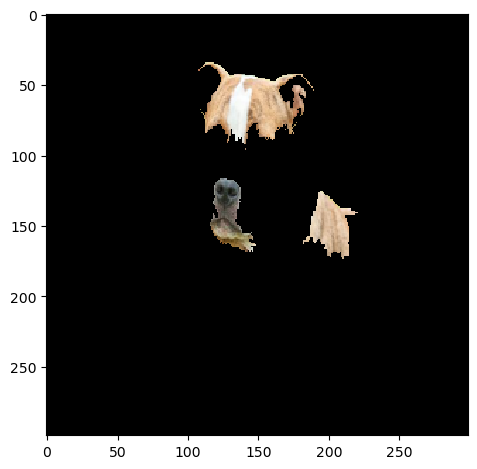

In [31]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

This is the final step where we obtain the area of the image that produced the prediction of American_Staffordshire_terrier.

## <font color="FFC300">Comment</font>:
- In the context of LIME, each superpixel is treated as an individual feature. The model was fitted (simpler_model>> a Linear Regression model) is an interpretable model that approximates the behavior of complex model (Inception V3) locally, around the specific instance being explained.<br>
- By examining these coefficients, we can infer which parts of image or which (superpixels) of the image are most important for classifying it as the specific class indicated by class_to_explain.

## Hyper-parameetr turning:

### 1.Changing max_dist:

max_dist controls the maximum distance between pixels for them to be considered part of the same superpixel.
Increasing max_dist results in larger superpixels and then pixels farther apart can now be grouped together. However, decreasing max_dist would creates smaller superpixels by limiting the grouping to pixels that are closer together.
Larger superpixels might capture more extensive and diverse parts of the image in each segment and smaller superpixels might capture finer details.

### 2.Adjusting ratio:

The ratio parameter balances color similarity and proximity in the segmentation process. A lower ratio puts emphasis on color similarity and whereas a higher ratio gives more importance to the spatial proximity of the pixels. Changing the ratio can alter the homogeneity of the superpixels. A lower ratio might create superpixels that are more consistent in color but possibly irregular in shape. A higher ratio might produce more compact superpixels that prioritize spatial closeness over color uniformity. Reference: www.google.com